In [1]:
import io
import os
import h5py
import yaml
import numba
#import pickle
import warnings
import numpy as np
import pandas as pd
#import pkg_resources
#from hoki import load
import scipy.integrate
import hoki.data_compilers
from hoki.constants import *
from hoki.csp.csp import CSP
from hoki.csp.sfh import SFH
#import hoki.csp.utils as utils
import matplotlib.pyplot as plt
from scipy.optimize import fminbound
from hoki.utils.hoki_object import HokiObject
from hoki.utils.exceptions import HokiDeprecationWarning, HokiKeyError, HokiFatalError, HokiTypeError, HokiFormatError

In [ ]:
# CSP class #

In [2]:
class CSP(object):
    """
    Complex Stellar Population parent class for 'CSPEventRate'

    Attributes
    ----------
    now (float) : age of the universe
    """
    now = HOKI_NOW

    def __init__(self):
        pass

    def check_histories(self, SFH, ZEH):
        """
        Function to check SFH and ZEH are correct type and transforms them into a consistent format.

        Parameters
        ----------
        SFH (callable python function/list of callables) : stellar formation history
        ZEH (callable python function/list of callables) : Z evolution history

        Returns
        -------
        (SFH, ZEH) (tuple) : tuple containing the SFH callables and ZEH callables as arrays
        """
        if isinstance(SFH, list):  # check if SFH is a list
            if isinstance(ZEH, list):  # check if ZEH is also a list
                if len(SFH) == len(ZEH):  # check SFH and ZEH are equal in length
                    if (all(callable(val) for val in SFH) and all(callable(val) for val in ZEH)):  # check all are callables
                        return (SFH, ZEH)
                    else:
                        raise HokiTypeError("SFH or ZEH contains an object that's not a SFH object or function.")
                else:
                    raise HokiFormatError(
                        "SFH and ZEH must have the same length.")
            else:
                if len(SFH) == 1:
                    if (callable(SFH[0]) and callable(ZEH)):
                        return (SFH, [ZEH])
                    else:
                        raise HokiTypeError("SFH or ZEH contains an object that's not a SFH object or python callable.")
                else:
                    raise HokiFormatError("SFH must have length 1, be a python callable, or a SFH object.")
        elif callable(SFH):  # if SFH is a callable
            if isinstance(ZEH, list):
                if len(ZEH) == 1:  # list has be to 1 long as SFH is callable
                    return ([SFH], ZEH)
                else:
                    raise HokiFormatError("ZEH must be either length 1 or a python callable")
            elif callable(ZEH):  # if ZEH is also a callable
                return ([SFH], [ZEH])
            else:
                raise HokiTypeError("ZEH is not a python callable or a list of callables.")
        else:  # if SFH cannot be identified
            raise HokiTypeError("SFH type is not a python callable or a SFH object.")

In [ ]:
# HokiObject class #

In [3]:
class HokiObject(object):
    t = BPASS_TIME_BINS
    dt = BPASS_TIME_INTERVALS
    time_weight_grid = BPASS_TIME_WEIGHT_GRID

    def __init__(self):
        pass

In [ ]:
# CSPEventRate class #

In [4]:
class CSPEventRate:
    """
    Object to calculate event rates using complex stellar formation histories.

    Parameters
    ----------
    data_path (str) : folder containing the BPASS data files (in units #events per bin)
    imf (str) : BPASS identifier for the IMF of the BPASS event rate files - accepted IMF identifiers include: "imf_chab100", "imf_chab300", 
        "imf100_100", "imf100_300", "imf135_100", "imf135_300", "imfall_300", "imf170_100", "imf170_300"
    
    Attributes
    ----------
    bpass_rates (pandas.DataFrame) : shape (51, (8, 13)) - BPASS delay time distributions in #events/yr/M_\odot per metallicity - 
        usage: rates.loc[log_age, (type, metallicity)]
    """
    def __init__(self, data_path, binary=True):
        self.bpass_rates = normalise_rates(rates_all_z(data_path, binary=binary))
        
        # shape (8, 13, 51) [event_type, metallicity, time_bin]
        self._numpy_bpass_rates = self.bpass_rates[BPASS_EVENT_TYPES].T.to_numpy().reshape((len(BPASS_EVENT_TYPES), 13, 51))

    def over_time(self, SFH, ZEH, event_type_list, nr_time_bins, return_time_edges=False):
        """
        Calculates event rates over lookback time for the function input.

        Parameters
        ----------
        SFH (python callable) : can be: python callable function which takes the lookback time and returns the stellar formation rate in 
            units M_\odot per yr at the given time / list of python callables with the above requirement / 'hoki.csp.sfh.SFH' object / list 
            of 'hoki.csp.sfh.SFH' objects
        ZEH (list(callable)) : can be: python callable function which takes the lookback time and returns the metallicity at the given time /
            list of python callables with the above requirement
        event_type_list (list(str)) : available types include: Ia, IIP, II, Ib, Ic, LGRB, PISNe, or low_mass
        nr_time_bins (int) : number of bins to split the lookback time into
        return_time_edges (bool) : if 'True', returns the edges of the lookback time bins (default = 'False')

        Returns
        -------
        event_rates (ndarray) : (nr_sfh, nr_event_types, nr_time_bins), ((nr_sfh, nr_event_types, nr_time_bins), nr_time_bins) - 
            if `return_time_edges=False`, returns a `numpy.ndarray` containing the event rates.
            usage: event_rates[1]["Ia"][10] (Gives Ia event rates in bin number 11 for the second sfh and metallicity history pair)
            if `return_time_edges=True`, returns a numpy array containing the event rates and the edges: out[0]=event_rates, out[1]=time_edges
        """
        SFH, ZEH = self.check_histories(SFH, ZEH)  # transform input to the correct shape

        if isinstance(event_type_list, type(list)):
            raise HokiFatalError("event_type_list is not a list. Only a list is taken as input.")

        nr_events = len(event_type_list)
        nr_sfh = len(SFH)
        output_dtype = np.dtype([(event, np.float64, nr_time_bins) for event in event_type_list])
        event_rates = np.empty(nr_sfh, dtype=output_dtype)
        time_edges = np.linspace(0, HOKI_NOW, nr_time_bins+1)
        bpass_rates = self._numpy_bpass_rates[[BPASS_EVENT_TYPES.index(event) for event in event_type_list]]
        mass_per_bin_list = np.array([mass_per_bin(rate, time_edges) for rate in SFH])
        metallicity_per_bin_list = np.array([metallicity_per_bin(Z, time_edges) for Z in ZEH])
        
        for counter, (mass_per_bin, Z_per_bin) in enumerate(zip(mass_per_bin_list, metallicity_per_bin_list)):
            for count in range(nr_events):
                event_rate = _over_time(Z_per_bin, mass_per_bin, time_edges, bpass_rates[count])
                event_rates[counter][count] = event_rate/np.diff(time_edges)

        if return_time_edges:
            return np.array([event_rates, time_edges], dtype=object)
        else:
            return event_rates

    def grid_over_time(self, SFH_list, time_points, event_type_list, nr_time_bins, return_time_edges=False):
        """
        Grid calculator to calculate event rates for the given BPASS event types for the given SFH

        Parameters
        ----------
        SFH_list (ndarray) : shape (N, 13, M) [nr_sfh, metalllicities, time_points] - list of N stellar formation histories divided into BPASS
            metallicity bins, over lookback time points with length M.
        time_points (ndarray) : shape (M) - array of lookback time points at which the SFH is given in the SFH_list
        event_type_list (list(str)) : list of BPASS event types - available types include: Ia, IIP, II, Ib, Ic, LGRB, PISNe, or low_mass
        nr_time_bins (int) : number of time bins in which to divide the lookback time
        return_time_edges (bool) : if 'True', returns the edges of the lookback time bins (default = 'False')

        Returns
        -------
        event_rate_list (ndarray) : shape (N, 13, nr_events, nr_time_bins) - array containing the event rates per galaxy (N), per metallicity (13),
            per event type (nr_events) and per time bins (nr_time_bins)
            if `return_time_edges=True`, returns a numpy array containing the event rates and the edges: out[0]=event_rates, out[1]=time_edges
        """
        nr_sfh = SFH_list.shape[0]
        nr_events = len(event_type_list)
        time_edges = np.linspace(0, HOKI_NOW, nr_time_bins+1)
        bpass_rates =  self._numpy_bpass_rates[[BPASS_EVENT_TYPES.index(event) for event in event_type_list]]
        event_rate_list = np.zeros((nr_sfh, 13, nr_events, nr_time_bins), dtype=np.float64)
        
        for sfh in range(nr_sfh):
            event_rate_list[sfh] = self._grid_rate_calculator_over_time(bpass_rates, SFH_list[sfh], time_points, nr_time_bins)

        if return_time_edges:
            return np.array([event_rate_list, time_edges], dtype=object)
        else:
            return event_rate_list

    @staticmethod
    @numba.njit(parallel=True, cache=True)
    def _grid_rate_calculator_over_time(bpass_rates, SFH, time_points, nr_time_bins):
        """
        Grid rate calculator to calculate the event rates for specific BPASS rates over time

        Parameters
        ----------
        bpass_rates (ndarray) : shape (M, 13, 51) [event_type, metallicity, time_bin] - array containing the BPASS event rates per event type (M),
            metallicity and BPASS time bin.
        SFH (ndarray) : shape (13, N) [metallicity, SFH_time_sampling_points] - SFH for each metallicity at the time_points
        time_points (ndarray) : time points at which the SFH is sampled (N)
        nr_time_bins (int) : number of time points in which to split the lookback time (final binning)

        Returns
        -------
        event_rates (ndarray) : shape (13, M, nr_time_bins) - array containing the event rates per metallicity (13) per event type (M) per time bins
        """
        nr_event_type = bpass_rates.shape[0]
        event_rates = np.empty((13, nr_event_type, nr_time_bins), dtype=np.float64)
        time_edges = np.linspace(0, HOKI_NOW, nr_time_bins+1)
        mass_per_bin_list = np.empty((13, nr_time_bins), dtype=np.float64)

        for index in numba.prange(13):  # calculating mass per bin for each metallicity
            mass_per_bin_list[index] = _optimised_mass_per_bin(time_points, SFH[index], time_edges, sample_rate=25)

        for counter in numba.prange(13):  # looping over metallicities
            for count in numba.prange(nr_event_type):  # looping over event type
                event_rate = _over_time(np.ones(nr_time_bins)*BPASS_NUM_METALLICITIES[counter], mass_per_bin_list[counter], time_edges,
                                              bpass_rates[count])
                event_rates[counter][count] = event_rate/np.diff(time_edges)
        return event_rates

In [ ]:
# CSPEventRate functions #

In [5]:
def _sn_rates(path):
    """
    Loads One Supernova rate file into a dataframe
    """
    return pd.read_csv(path, sep=r"\s+", names=['log_age', 'Ia', 'IIP', 'II', 'Ib', 'Ic', 'LGRB', 'PISNe', 'low_mass', 'e_Ia', 'e_IIP', 'e_II',
                                                'e_Ib', 'e_Ic', 'e_LGRB', 'e_PISNe', 'e_low_mass', 'age_yrs'], engine='python')

In [6]:
def model_output(path):
    """
    Loads a BPASS output file

    Parameters
    ----------
    path (str) : path to the file containing the target data.

    Returns
    -------
    Output Data (pandas.DataFrame / hoki.hrdiagrams.HRDiagrams object) : desired output data
    """
    assert isinstance(path, str), "HOKI ERROR: The location of the file is expected to be a string."
    assert os.path.isfile(path), "HOKI ERROR: This file does not exist, or its path is incorrect."

    if "supernova" in path:
        return _sn_rates(path)

    else:
        print("HOKI ERROR -- Could not load the Stellar Population output.")

In [7]:
@numba.njit(cache=True)
def _optimised_mass_per_bin(time_points, sfh, time_edges, sample_rate=25):
    """
    Mass per bin calculation from grid data

    Parameters
    ----------
    time_point (ndarray) : shape (N) - time points at which the SFH is sampled
    sfh (ndarray) : shape (N) - SFH at the time_point samples
    time_edges (ndarray) : shape (M) - edges of the bins in which the mass per bin is wanted in yrs.
    sample_rate (int) : number of samples to take to use for the trapezodial integration (default = 25)

    Returns
    -------
    out (ndarray) : shape (M-1) - array of the mass per time bin
    """
    l = len(time_edges)-1  # equivalent to nr_bins
    out = np.empty(l)
    for num in range(l):  # subsample and interpolate for inbetween values
        x = np.linspace(time_edges[num], time_edges[num+1], sample_rate)
        y = np.interp(x, time_points, sfh)
        out[num] = _optimised_trapezodial_rule(y,x)
    return out

In [8]:
def normalise_rates(rates):
    """
    Normalise the given BPASS event rates.

    Parameters
    ----------
    rates (pandas.DataFrame) : Pandas DataFrame containing the the events per bin

    Returns
    -------
    event_rates (pandas.DataFrame) : Pandas DataFrame containing the events/yr/M_\odot
    """
    event_rates = rates / (1e6 * BPASS_LINEAR_TIME_INTERVALS[:, None])
    return event_rates

In [9]:
def rates_all_z(data_path, binary=True):
    """
    Loads the BPASS supernova event files.
    
    Parameters
    ----------
    data_path (str) : filepath to the folder containing the BPASS data (no backslash needed on the end)
    binary (bool) : if `True`, loads the binary filese (default = 'True')
    
    Returns
    -------
    bpass_rates (pandas.DataFrame) : shape (51, (8, 13)) (log_age, (event_types, metallicity) - dataframe containing BPASS number of events per 
        metallicity per type
        usage: rates.loc[log_age, (type, metallicity)]
    """
    star = "bin" if binary else "sin"  # determines population type

    arrays = [1, BPASS_EVENT_TYPES]  # create output dataframe with shape (1, 8) (metallicity, event type)
    columns = pd.MultiIndex.from_product(arrays, names=["Metallicity", "Event Type"])
    rates = pd.DataFrame(index=BPASS_TIME_BINS, columns=columns, dtype=np.float64)
    rates.index.name = "log_age"

    for num, metallicity in enumerate(BPASS_METALLICITIES):
        data = model_output(f"{data_path}/supernova-{star}-imf135_300.{metallicity}.dat.gz")  # loads BPASS supernova files - change file path here
        data = data.loc[:, slice(BPASS_EVENT_TYPES[0], BPASS_EVENT_TYPES[-1])]
        rates.loc[:, (BPASS_NUM_METALLICITIES[num], slice(None))] = data.to_numpy()

    bpass_rates = rates.swaplevel(0, 1, axis=1)  # swaps metallicity and event type
    return bpass_rates

In [10]:
@numba.njit(cache=True)
def _optimised_trapezodial_rule(y,x):
    """
    Basic Trapezodial rule integration

    Parameters
    ----------
    y (ndarray) : N y values corresponding to 'x'
    x (ndarray) : N x values

    Returns
    -------
    s/2 (float) : trapezodial integral over the given values
    """
    s = 0
    for num in range(1, len(x)):
        s += (x[num]-x[num-1])*(y[num]+y[num-1])
    return s/2

In [11]:
@numba.njit(cache=True)
def trapz_loop(dp, fp, sample_rate):
    """
    Perform a trapezodial integration over subsections of the given arrays.

    Parameters
    ----------
    dp (ndarray) : contains N time points
    fp (ndarray) : contains N function values at the time points
    sample_rate (int) : sample rate over which to integrate the values - (N-1) has to be divisible by 'sample_rate'

    Returns
    -------
    out (ndarray) : (N-1)/'sample_rate' - array containing the integrals over bins separated by 'sample_rate'
    """
    nr_bins = int((len(dp)-1)/sample_rate)

    out = np.empty(nr_bins)
    for bins in range(nr_bins):  # find indices containing the subsampled points of the bin
        j1 = bins*sample_rate
        j2 = (bins+1)*sample_rate + 1
        out[bins] = _optimised_trapezodial_rule(fp[j1:j2],dp[j1:j2])
    return out

In [12]:
def mass_per_bin(sfh_function, time_edges, sample_rate=25):
    """
    Calculates the mass per bin for the given edges in time.

    Parameters
    ----------
    sfh_function (callable) : python callable function giving the stellar formation rate at a given lookback time
    time_edges (ndarray) : edges of the bins in yrs
    sample_rate (int) : number of samples to take to use for the trapezodial integration (default = 25)

    Returns
    -------
    mass_per_time_bin (ndarray) : [len(time_edges)-1] - mass per time bin
    """
    dif = np.diff(time_edges)
    if np.allclose(dif,dif[0]):
        dp = np.linspace(time_edges[0], time_edges[-1], (sample_rate-1)*(len(time_edges)-1)+len(time_edges))
    else:
        dp = np.array([np.linspace(t1, t2, sample_rate+1)[:-1] for t1, t2 in zip(time_edges[:-1], time_edges[1:])])
        dp = np.append(dp, time_edges[-1])  # adds final time edge back in

    try:
        fp = sfh_function(dp)
    except ValueError:
        fp = np.vectorize(sfh_function)(dp)

    if type(fp) != np.ndarray or len(fp) != len(dp):
        fp = np.vectorize(sfh_function)(dp)

    mass_per_time_bin = trapz_loop(dp, fp, sample_rate)
    return mass_per_time_bin

In [13]:
def metallicity_per_bin(Z_function, time_edges):
    """
    Gives the metallicity per bin for the given edges in time.

    Parameters
    ----------
    Z_function (function) : function giving the metallicity history given a lookback time
    time_edges (ndarray) : edges of the bins in which the mass per bin is wanted in yrs

    Returns
    -------
    Z_average (ndarray) : [len(time_edges)-1] - average metallicity per time bin
    """
    try:
        Z_values = Z_function(time_edges)
    except ValueError:
        Z_values = np.vectorize(Z_function)(time_edges)

    if type(Z_values) != np.ndarray or len(Z_values) != len(time_edges):
        Z_values = np.vectorize(Z_function)(time_edges)

    Z_average = np.array((Z_values[1:] + Z_values[:-1]) / 2)
    return Z_average

In [14]:
@numba.njit(cache=True)
def _get_bin_index(x, edges):
    """
    Gets the bin number given the edges.

    Parameters
    ----------
    x (float) : value where the bin number is needed to be known
    edges (ndarray) : array with the edges of the histogram
    
    Returns
    -------
    out (int) : bin index of x

    """
    if x < edges[0] or x > edges[-1]:  # checks if x is within the edge ranges
        raise HokiFormatError("x outside of range")

    out = 0
    if x == edges[-1]:  # if x is equal to the last bin, return len-2
        out = len(edges) - 2

    for i, val in enumerate(edges):
        if val > x:  # x larger than bin, return answer
            out = i - 1
            break
    return int(out)

In [15]:
@numba.njit(cache=True)
def _integral(x1, x2, edges, values, bin_width):
    """
    Perfoms an intergral over histogram-like binned data.

    Parameters
    ----------
    x1 (float) : lower bound of the integration
    x2 (float) : upper bound of the integration
    edges (ndarray) : edges of the bins
    values (ndarray) : values in each bin
    bin_width (ndarray) : width of each bin

    Returns
    -------
    total (float) : integral between 'x1' and 'x2'

    """
    lower_bin = _get_bin_index(x1, edges)
    upper_bin = _get_bin_index(x2, edges)

    total = 0

    # Values within the same bin. Return fraction of the bin
    if lower_bin == upper_bin:
        total = values[lower_bin] * (x2 - x1)
    else:
        # Add part of the lower and upper bin to the total
        ledge = lower_bin + 1
        total += (values[lower_bin] * (edges[ledge] - x1))
        total += (values[upper_bin] * (x2 - edges[upper_bin]))

        # Add any remaining bins to the total
        if ledge < upper_bin:
            total += np.sum(bin_width[ledge:upper_bin]
                            * values[ledge:upper_bin])

    return total

In [16]:
@numba.njit(cache=True)
def _over_time(Z_per_bin, mass_per_bin, time_edges, bpass_rates):
    """
    Calculates the events rates per bin over the given bin edges.

    Parameters
    ----------
    Z_per_bin (ndarray) : shape N - array containing the metallicity values in each time bin
    mass_per_bin (ndarray) : shape N - array containing the mass per time bin
    time_edges (ndarray) : shape N+1 - bin edges of Z_per_bin and mass_per_bin
    bpass_rates (ndarray) : shape (13, 51) [metallicity, log_age] - 2D array containing the event rates for all BPASS metallicities over time 
        in BPASS bins
        usage: bpass_rates[0][2] (gives the event rate at the metallicity 0.00001 and a log_age of 6.2)

    Returns
    -------
    event_rate (ndarray) : shape N - number of events per bin
    """
    Z_index_per_bin = np.array([np.argmin(np.abs(Z - BPASS_NUM_METALLICITIES)) for Z in Z_per_bin])
    event_rate = np.zeros(len(mass_per_bin))

    for count in range(len(mass_per_bin)):
        t = time_edges[count + 1]
        for num in range(0, count + 1):
            p1 = t - time_edges[num]
            p2 = t - time_edges[num + 1]
            bin_events = _integral(p2, p1, BPASS_LINEAR_TIME_EDGES, bpass_rates[Z_index_per_bin[count]], BPASS_LINEAR_TIME_INTERVALS)
            event_rate[num] += bin_events * mass_per_bin[count]
    return event_rate

In [41]:
# test with data.h5 file

In [17]:
file = h5py.File("./data.h5", "r")
SFH = file['SFH']['TNG']
event_types = ["Ia", "IIP", "II", "Ib", "Ic", "LGRB", "PISNe"]

In [18]:
@np.vectorize
def calc_LB(z, omega0, omega1, hubble):
    '''
    Calculates the lookback time according to Hobbs.

    Parameters:
    z : float
        The redshift at which you want to calculate the lookback
    omega0 : float
        The Matter density parameter (0.3111 Planck 2018)
    omega1 : float
        The dark energy density parameter (0.6889 Planck 2018)
    hubble : float
        The hubble parameters (0.6766 Planck 2018)
    '''
    def func(x):
        E = np.sqrt(omega0*(1+x)**3 + omega1)
        return 1/((1+x)*E)
    # can be simplified by already doing the extra coefficient calculations
    t_hubble = (1/(100*hubble))*3.0856776*10**19
    return t_hubble *scipy.integrate.quad(func, 0, z)[0]/(60*60*24*365.2388526)

lookback_time = calc_LB(SFH.attrs['redshift'], 0.3111, 0.6889, 0.6766)

In [19]:
SFH_input = SFH[:].reshape(1, SFH.shape[0], SFH.shape[1])*1e9  #Transform SFR from per Myr^-3 to Gpc6-3$
er_csp = CSPEventRate('./BPASS data', binary=True)

In [20]:
out, edges = er_csp.grid_over_time(SFH_input, lookback_time, event_types , 100, return_time_edges=True)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [21]:
out = out[0]

In [22]:
CCSN_rates = np.sum(out[:,1:5], axis=0).sum(axis=0)

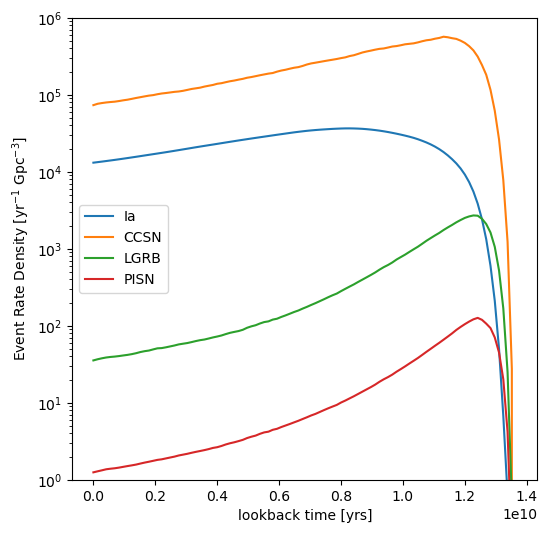

In [27]:
fig = plt.figure(figsize=(6,6))
plt.plot(edges[:-1],  np.sum(out[:,0], axis=0), label='Ia')
plt.plot(edges[:-1],  CCSN_rates, label='CCSN')
plt.plot(edges[:-1],  np.sum(out[:,5], axis=0), label='LGRB')
plt.plot(edges[:-1],  np.sum(out[:,6], axis=0), label='PISN')

plt.yscale('log')
plt.ylim(1e0, 1e6)
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
plt.legend()
plt.show()